In [252]:
import json
import os

#results_dir = "results/extendedTests/iot-coldstarts-6xni/"
#results_dir = "results/finalTests/IoT-normal-latency-7x1000/"
results_dir = "results/finalTests/IoT-coldStart-latency-7x300/"
#results_dir = "results/finalTests/split-normal-latency-5x1000/"
#results_dir = "results/finalTests/split-coldStart-latency-6x300/"
json_files = [pos_json for pos_json in os.listdir(results_dir) if pos_json.endswith('.json')]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        print(f'Read fusion group {fusion_group} with {len(content)} lines')
        data.extend(content)

Read fusion group AS,CA.DJ,CS.CSA.CSL,CT,CW,I,SE with 2398 lines
Read fusion group AS,CA.DJ,CS,CSA,CSL,CT,CW,I,SE with 2994 lines
Read fusion group AS,CA.DJ,CS.CSA.CSL,CT,CW.I.SE with 3595 lines
Read fusion group AS,CA.DJ,CS.CSA,CSL,CT,CW,I,SE with 2697 lines
Read fusion group AS,CA.DJ,CS.CSA.CSL,CT,CW.SE,I with 2400 lines
Read fusion group AS,CA,CS,CSA,CSL,CT,CW,DJ,I,SE with 3291 lines


In [253]:
# This is a single invocation
# data[0]

In [254]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

sns.set(rc={'figure.figsize':(6,5)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('axes', unicode_minus=False)

def save_fig(ax, name, file_type="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()
    file_name = name + "." + file_type
    fig.savefig(os.path.join("graphs", file_name), bbox_inches='tight')


df = pd.DataFrame.from_dict(data)

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
df["duration"] =  df["endTimestamp"] - df["startTimestamp"]
df["fusionGroup"] = df["fusionGroup"].str.replace(",", "/")

df

,traceId,fusionGroup,source,currentFunction,billedDuration,maxMemoryUsed,isRootInvocation,startTimestamp,endTimestamp,internalDuration,calls,duration
0,eeaf149ad7f57f224fd4186f5f1a59c4d944d0ce0a8b5a...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,190,77,False,13957202,13957383,160,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",181
1,eeaf149ad7f57f224fd4186f5f1a59c4d944d0ce0a8b5a...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,1373,82,False,13957449,13958822,1274,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",1373
2,956858f27e15631d540c13e46e9bdca7ab8ffa71533c70...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,1362,81,False,13553316,13554676,1339,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",1360
3,bdb6bb6883297cc83109d0bd7908e97f97758980c888ff...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,197,76,False,13217878,13218073,173,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",195
4,7ed4df036ca6a88ababf2884c00037ee898373fffea179...,AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE,I,AS,203,76,False,14906849,14907051,163,"[{'called': 'AS', 'caller': 'AS', 'local': Tru...",202
...,...,...,...,...,...,...,...,...,...,...,...,...
17370,e5fba1f5c63e8c07c9f6d0da881b593d2406e67dc62130...,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,I,SE,740,79,False,964365,965103,700,"[{'called': 'SE', 'caller': 'SE', 'local': Tru...",738
17371,7859e8533f4f76a3fd7c243491961b348f64ee3d6548e0...,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,I,SE,720,79,False,991148,991866,643,"[{'called': 'SE', 'caller': 'SE', 'local': Tru...",718
17372,d71b77a5315aa506a49764efbe05d7db5ec95ec9bfa401...,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,I,SE,741,79,False,1296204,1296943,736,"[{'called': 'SE', 'caller': 'SE', 'local': Tru...",739
17373,2d8ac8b8432fbd33fc96128ce49777f714d82e29ca265f...,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,I,SE,736,79,False,1637595,1638328,731,"[{'called': 'SE', 'caller': 'SE', 'local': Tru...",733


In [255]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 2100


<AxesSubplot:ylabel='billedDuration'>

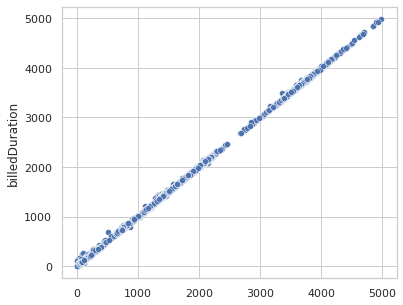

In [256]:
sns.scatterplot(data=df, x=df["endTimestamp"]-df["startTimestamp"], y="billedDuration")

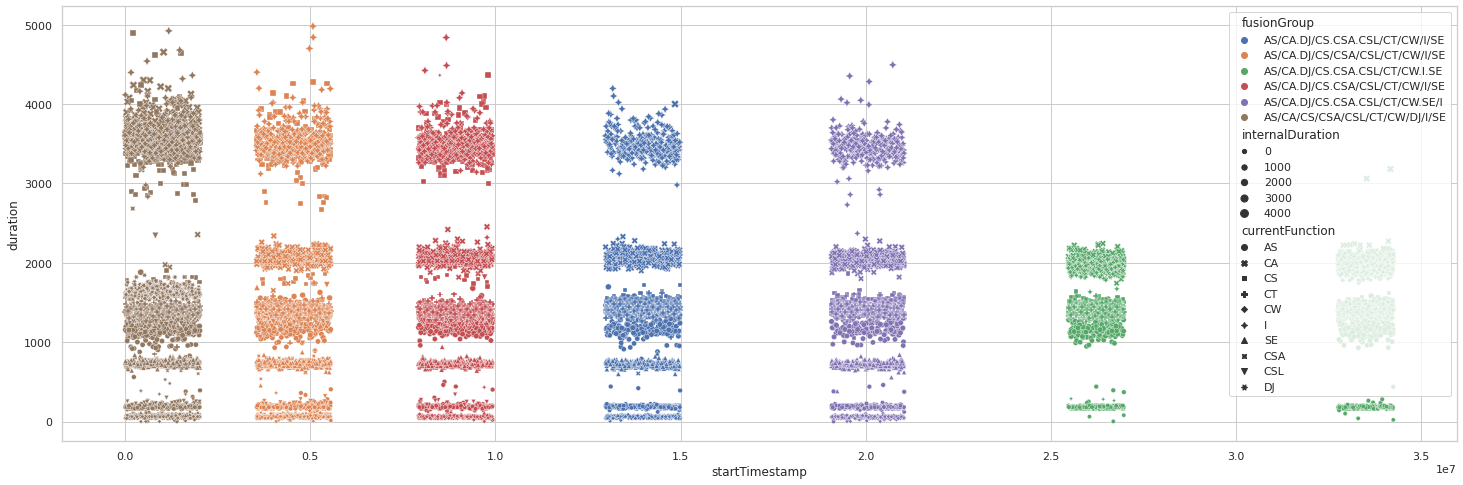

In [257]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=df, x="startTimestamp", y="duration", size="internalDuration", hue=df["fusionGroup"], style="currentFunction")
plt.savefig("pointCloud.pdf")

<AxesSubplot:xlabel='startTimestamp', ylabel='10s_billedDuration_avg'>

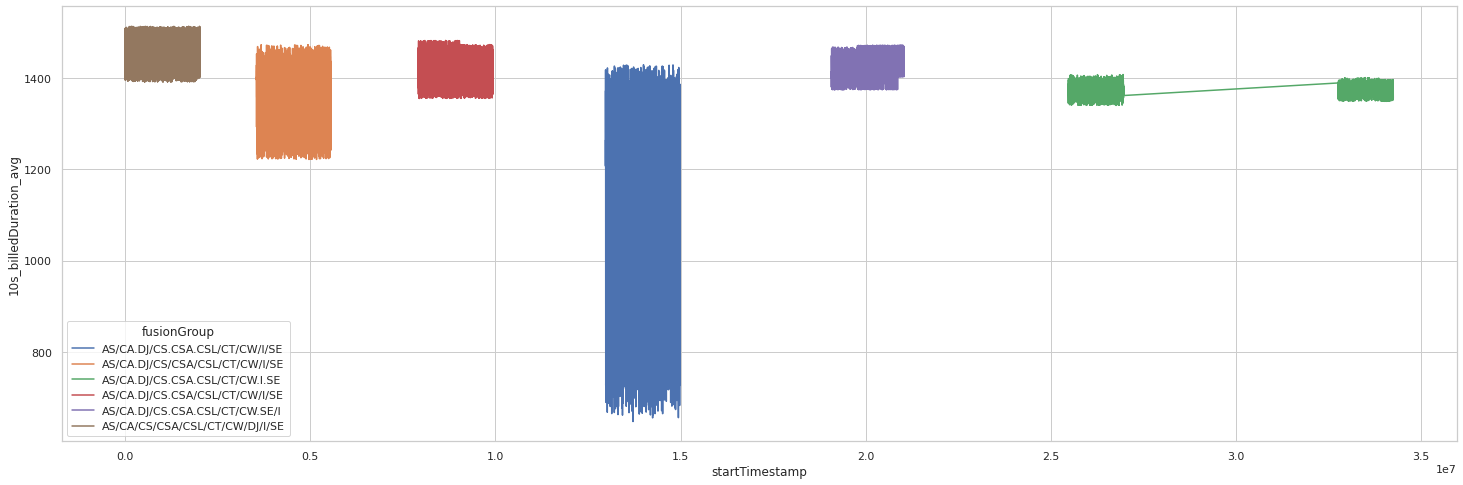

In [258]:
plt.figure(figsize=(25,8))
df['10s_billedDuration_avg'] = df['billedDuration'].rolling(10000, min_periods=30).mean()
#df['10s_billedDuration_med'] = df['billedDuration'].rolling(10000, min_periods=30).median()
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_avg", hue=df["fusionGroup"])
#sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_med", hue=df["fusionGroup"])
#sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", hue=df["fusionGroup"], legend=None)

In [259]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min'})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

# Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
# Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]

grouped

Total Number of Invocations should be: 17375 == 17375


/tmp/ipykernel_11602/2807751757.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,000d09bdb3a7ee0c5c34a2e4b3a66f903461fd5cf5496a...,8173,26622753,26628884,AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE,6,26624576,1823
1,003157ac752796189dc14b16d598c66807f819d6f55454...,10961,20908397,20915982,AS/CA.DJ/CS.CSA.CSL/CT/CW.SE/I,8,20912139,3742
2,003be65b41874b8ed38c82b17eee8808b56a2a93cb76f3...,13791,9375259,9382753,AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE,9,9378763,3504
3,005c1c2513571a7cd607b2fe49baec0c8ff644563f9329...,10641,20824875,20832248,AS/CA.DJ/CS.CSA.CSL/CT/CW.SE/I,8,20828556,3681
4,0073cb20f8b033fa051f9731091d3859c876d946a1271f...,8174,33176748,33182852,AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE,6,33178608,1860
...,...,...,...,...,...,...,...,...
2095,ff9d90ad3e5328c2c9af8dc0e420ec02912868be612d06...,10925,20238294,20246202,AS/CA.DJ/CS.CSA.CSL/CT/CW.SE/I,8,20241876,3582
2096,ffa60f5d0cddf7209dc14215383f17837e893c04222a33...,18151,1935775,1944603,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,1939277,3502
2097,ffddb777b549da1d1ceb445655279e5807e78dab79262f...,8674,19773229,19779580,AS/CA.DJ/CS.CSA.CSL/CT/CW.SE/I,8,19775600,2371
2098,ffeb0afa24c0c99eb05466d2d20f4de4301e16cac55a3c...,7962,33604669,33610114,AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE,6,33606534,1865


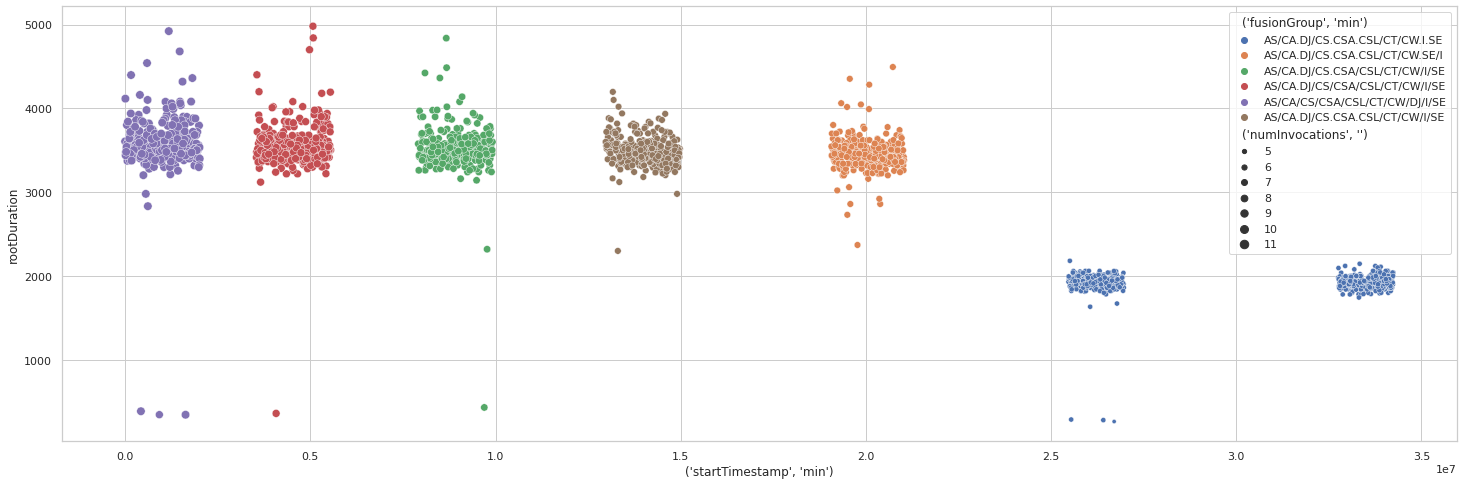

In [260]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("duration.pdf")

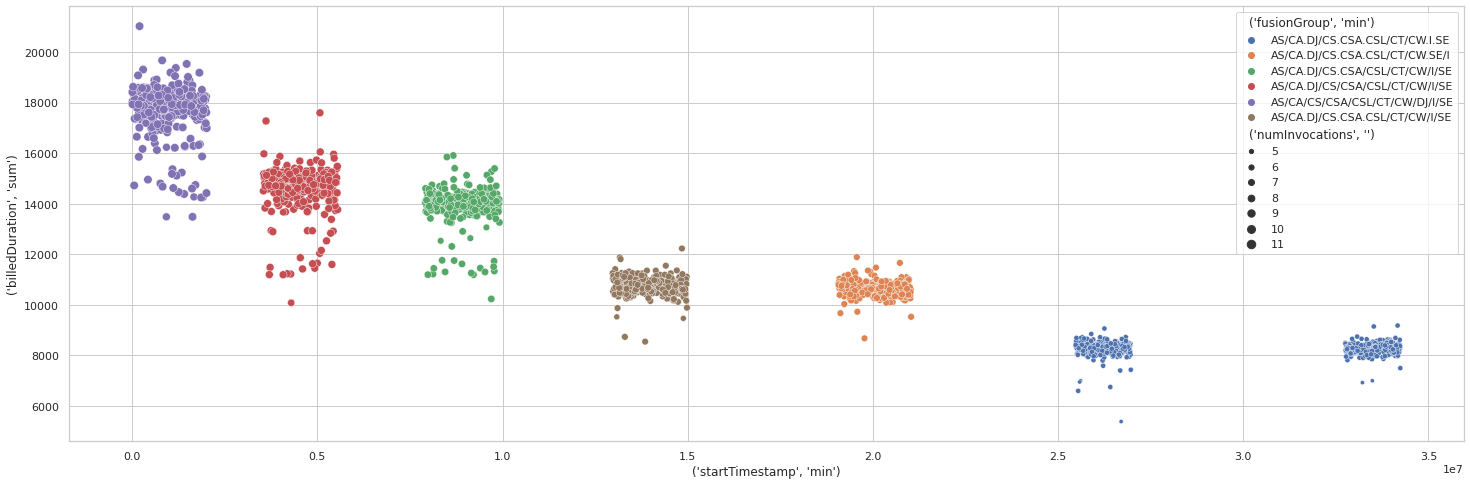

In [261]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("billed.pdf")

In [262]:
grouped[grouped["rootDuration"] <= 1000]

,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
174,142299e84586af9a200fca71ec2e73fb0dc57ba841defa...,10234,9697368,9702064,AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE,9,9697800,432
469,3c55f8e7fff65ef488a2720cd978661687f8d574adf9dd...,6748,26409809,26414012,AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE,6,26410090,281
1026,7fbf2ca0eaba6f73e5e59eab9654c417e68ccc5141041f...,13483,924824,930530,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,10,925170,346
1411,aca073b9e50e04cd36cd3b7c2b947524c7d7503bc9aac5...,14955,426907,432635,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,427294,387
1540,bc714bc5118bdeb92916046a22f8753357b601cae20066...,13483,1631534,1636510,AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE,11,1631879,345
1749,d575e1ca5dd8edb884ae308136d471b955d0e9e072b175...,11190,4076810,4081288,AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE,10,4077171,361
1835,e03cc3b7b6844fa7371a216dbca8bf8abc946d61eb9e86...,6595,25542257,25546259,AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE,6,25542545,288
1997,f2f90b5f111ccd37d54ef9a5d413133d27aa2dad2948d8...,5382,26701629,26704450,AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE,5,26701893,264


['AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE' 'AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE'
 'AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE' 'AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE'
 'AS/CA.DJ/CS.CSA.CSL/CT/CW.SE/I' 'AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE']


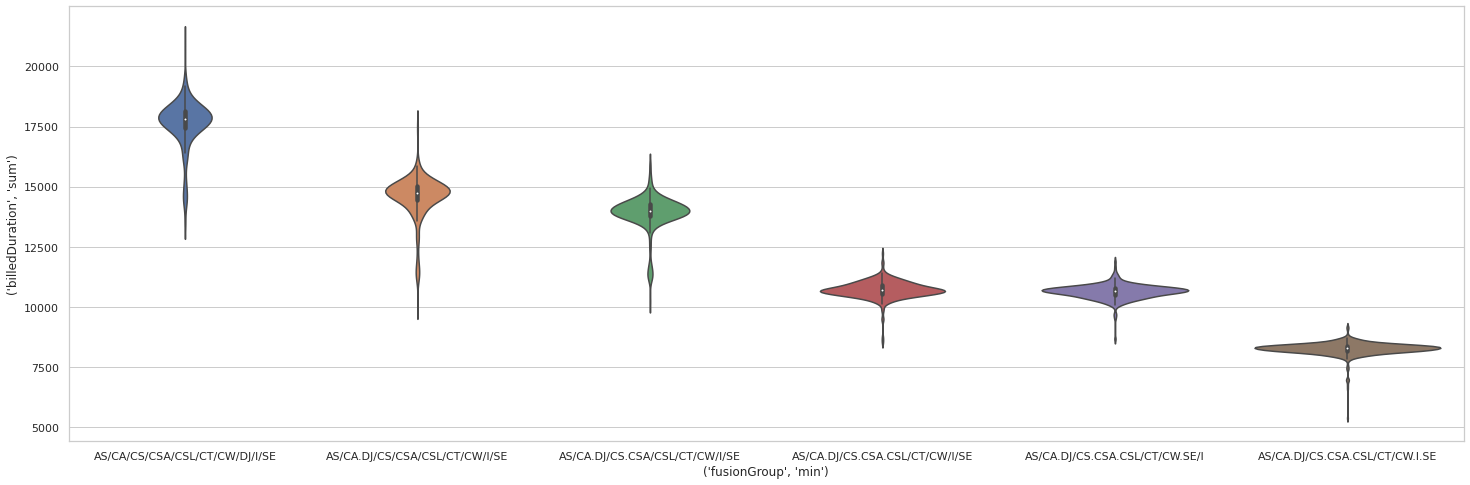

In [263]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['billedDuration', 'sum'], order=fusion_groups_order)
plt.savefig("violinBilled.pdf")

['AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE' 'AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE'
 'AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE' 'AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE'
 'AS/CA.DJ/CS.CSA.CSL/CT/CW.SE/I' 'AS/CA.DJ/CS.CSA.CSL/CT/CW.I.SE']


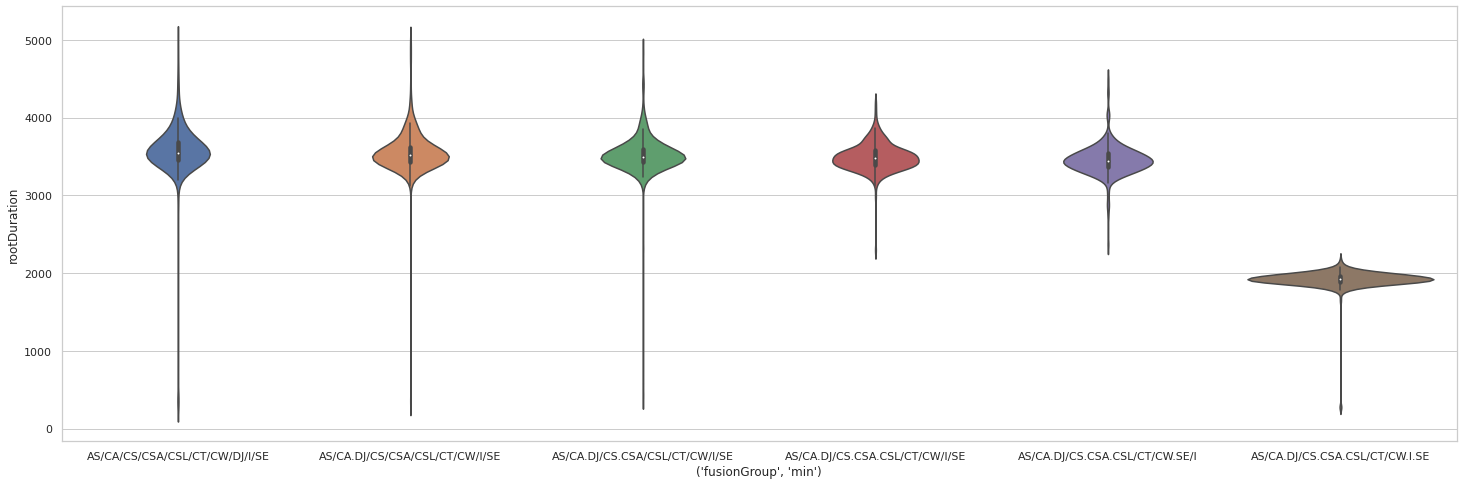

In [264]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['rootDuration'], order=fusion_groups_order)
plt.savefig("violinRR.pdf")

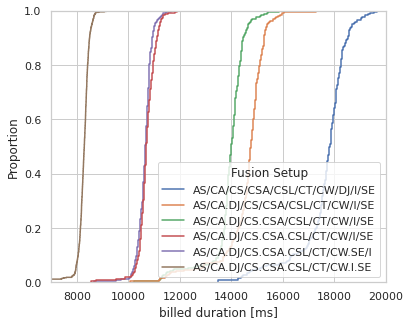

In [265]:
ax = sns.ecdfplot(data=grouped, x=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order)
plt.xlabel("billed duration [ms]")
ax.get_legend().set_title("Fusion Setup")
ax.set(xlim=(7000,20000))
plt.savefig("ecdfBilled.pdf")

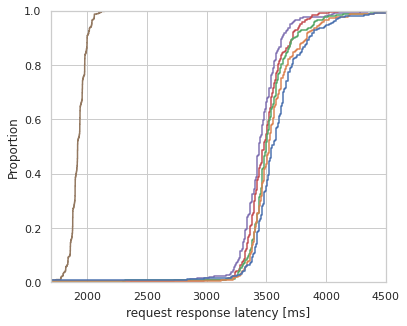

In [266]:
ax = sns.ecdfplot(data=grouped, x=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], hue_order=fusion_groups_order, legend=None)
plt.xlabel("request response latency [ms]")
#ax.get_legend().set_title("Fusion Group")
ax.set(xlim=(1700,4500))
plt.savefig("ecdfRR.pdf")

In [267]:
from scipy.stats import t

In [268]:
# Calculate Mean and Confidence Interval of billed duration and rootDuration

def printMeanAndCi(x, name=""):
    m = x.mean() 
    s = x.std() 
    dof = len(grouped)-1 
    confidence = 0.95

    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    print(f'Mean: {m:7.2f}, Confidence Interval: ({m-s*t_crit/np.sqrt(len(x)):7.2f} / {m+s*t_crit/np.sqrt(len(x)):7.2f}), Median: {x.median()} for {name}')

print("overall")
printMeanAndCi(grouped["rootDuration"], "rootDuration")
printMeanAndCi(grouped['billedDuration', 'sum'], "billedDuration")
for group in fusion_groups_order:
    filtered = grouped[grouped['fusionGroup', 'min'] == group]
    print(group)
    printMeanAndCi(filtered["rootDuration"], f'rootDuration')
    printMeanAndCi(filtered['billedDuration', 'sum'], f'billedDuration')

overall
Mean: 3061.98, Confidence Interval: (3029.31 / 3094.65), Median: 3423.0 for rootDuration
Mean: 12003.33, Confidence Interval: (11862.20 / 12144.45), Median: 10837.5 for billedDuration
AS/CA/CS/CSA/CSL/CT/CW/DJ/I/SE
Mean: 3568.17, Confidence Interval: (3523.37 / 3612.97), Median: 3545.5 for rootDuration
Mean: 17628.58, Confidence Interval: (17513.47 / 17743.69), Median: 17824.0 for billedDuration
AS/CA.DJ/CS/CSA/CSL/CT/CW/I/SE
Mean: 3555.48, Confidence Interval: (3522.52 / 3588.44), Median: 3521.0 for rootDuration
Mean: 14580.19, Confidence Interval: (14477.81 / 14682.57), Median: 14756.5 for billedDuration
AS/CA.DJ/CS.CSA/CSL/CT/CW/I/SE
Mean: 3521.81, Confidence Interval: (3490.79 / 3552.82), Median: 3500.0 for rootDuration
Mean: 13918.13, Confidence Interval: (13836.08 / 14000.19), Median: 13992.5 for billedDuration
AS/CA.DJ/CS.CSA.CSL/CT/CW/I/SE
Mean: 3493.31, Confidence Interval: (3473.37 / 3513.25), Median: 3481.5 for rootDuration
Mean: 10718.94, Confidence Interval: (10678

In [269]:
df["calls"]


0        [{'called': 'AS', 'caller': 'AS', 'local': Tru...
1        [{'called': 'AS', 'caller': 'AS', 'local': Tru...
2        [{'called': 'AS', 'caller': 'AS', 'local': Tru...
3        [{'called': 'AS', 'caller': 'AS', 'local': Tru...
4        [{'called': 'AS', 'caller': 'AS', 'local': Tru...
                               ...                        
17370    [{'called': 'SE', 'caller': 'SE', 'local': Tru...
17371    [{'called': 'SE', 'caller': 'SE', 'local': Tru...
17372    [{'called': 'SE', 'caller': 'SE', 'local': Tru...
17373    [{'called': 'SE', 'caller': 'SE', 'local': Tru...
17374    [{'called': 'SE', 'caller': 'SE', 'local': Tru...
Name: calls, Length: 17375, dtype: object

In [270]:
calls = df["calls"]
calls = np.concatenate(list(calls)).ravel()
calledI = np.array(list(filter(lambda el: el["called"] == "I", calls)))
#df["acutalInternalDuration"] = df.apply(lambda row: np.vectorize(lambda obj: obj["time"])(np.array(list(filter(lambda el: el["called"] == "I",np.concatenate(list(row["calls"])).ravel())))), axis=1)

#df.apply(lambda row: np.vectorize(lambda obj: obj["time"])(np.array(list(filter(lambda el: el["called"] == "I",np.concatenate(list(row["calls"])).ravel())))), axis=1)
#np.vectorize(lambda obj: obj["time"])(calledI)

In [271]:
def get_call_time_for_row(row):
    calls = list(np.array(row["calls"]).flat)
    #calls = np.concatenate(calls).ravel()
    calledI = np.array(list(filter(lambda el: el["called"] == el["caller"], calls)))
    return  calledI[0]["time"] if len(calledI) > 0 else -1
df["actualInternalDuration"] = df.apply(lambda row: get_call_time_for_row(row), axis=1)

all: mean: 37.96028589544066 median: 27.0 len: 17349


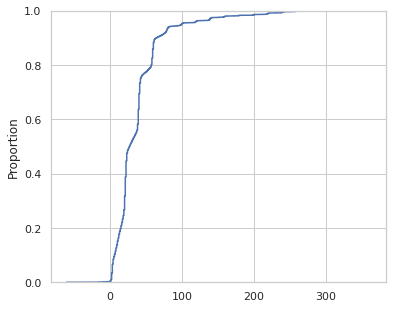

root: mean: 30.601812112541726 median: 25.0 len: 2097


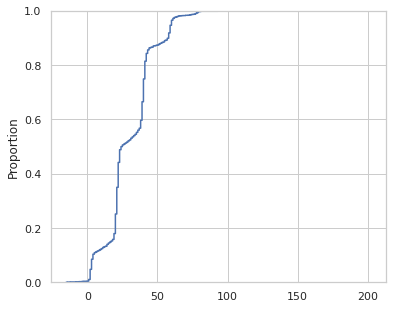

In [272]:
# Calculate the overhead of the handler

def calculate_handler_overhead(df, name = ""):
    df = df[df["actualInternalDuration"] > 0]
    oh = df["duration"] - df["actualInternalDuration"]
    print(f'{name}: mean: {oh.mean()} median: {oh.median()} len: {len(oh)}')
    sns.ecdfplot(data=df, x=df["duration"] - df["actualInternalDuration"])
    plt.show()

calculate_handler_overhead(df, "all")
calculate_handler_overhead(df[df['isRootInvocation'] == True], "root")